# Tutorial: Analyzing Edit Histories from Connectome Datasets

This notebook demonstrates the complete pipeline for:
1. Getting proofread neurons from MICrONS (mouse) dataset
2. Fetching edit histories for those neurons
3. Analyzing edit patterns (merge vs split, distributions)
4. Understanding the data structure

This is the core analysis for estimating computational proofreading costs.

In [2]:
import caveclient
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Step 1: Connect to MICrONS Dataset

The MICrONS dataset (mouse cortex) is publicly accessible via CAVEclient.

In [3]:
# Connect to MICrONS (minnie65_public dataset)
client = caveclient.CAVEclient("minnie65_public")

print(f"Connected to: {client.datastack_name}")
print(f"Server: {client.server_address}")

Connected to: minnie65_public
Server: https://global.daf-apis.com


In [4]:
# List all available tables
print("Available tables in materialize:")
print("=" * 50)

# get_tables() - returns a list of table names
tables = client.materialize.get_tables()
print(f"Found {len(tables)} tables:\n")
for i, table in enumerate(tables, 1):
    print(f"  {i}. {table}")


Available tables in materialize:
Found 40 tables:

  1. baylor_gnn_cell_type_fine_model_v2
  2. vortex_manual_myelination_v0
  3. synapse_target_predictions_ssa
  4. aibs_metamodel_celltypes_v661
  5. nucleus_alternative_points
  6. allen_column_mtypes_v2
  7. bodor_pt_cells
  8. aibs_metamodel_mtypes_v661_v2
  9. vortex_microglia_proofreading_status
  10. proofreading_status_and_strategy
  11. allen_v1_column_types_slanted_ref
  12. aibs_column_nonneuronal_ref
  13. nucleus_ref_neuron_svm
  14. apl_functional_coreg_vess_fwd
  15. vortex_axon_backtrace_column
  16. vortex_compartment_targets
  17. baylor_log_reg_cell_type_coarse_v1
  18. vortex_synapse_reattachment
  19. gamlin_2023_mcs_met_types
  20. gamlin_2023_mcs
  21. l5et_column
  22. pt_synapse_targets
  23. coregistration_manual_v4
  24. cg_cell_type_calls
  25. synapses_pni_2
  26. nucleus_detection_v0
  27. vortex_manual_nodes_of_ranvier
  28. bodor_pt_target_proofread
  29. nucleus_functional_area_assignment
  30. coregistr

## Step 2: Get Proofread Neurons

There are different ways to query neurons:
- **`query_table('proofreading_status_and_strategy')`**: Officially proofread neurons
- **`live_query('proofreading_status_and_strategy', datetime.now())`**: Live version (Jeff's approach)

Let's explore both and understand the difference between `pt_root_id` and `valid_id` columns.

In [5]:
# Method 1: query_table
table = client.materialize.query_table('proofreading_status_and_strategy')

print(f"Total records: {len(table):,}")
print(f"\nColumns: {list(table.columns)}")
print(f"\nFirst few rows:")
table.head()

Total records: 2,314

Columns: ['id', 'created', 'superceded_id', 'valid', 'valid_id', 'status_dendrite', 'status_axon', 'strategy_dendrite', 'strategy_axon', 'pt_supervoxel_id', 'pt_root_id', 'pt_position']

First few rows:


,id,created,superceded_id,valid,valid_id,status_dendrite,status_axon,strategy_dendrite,strategy_axon,pt_supervoxel_id,pt_root_id,pt_position
0,1526,2024-08-02 20:25:56.067777+00:00,<NA>,True,864691136195824204,True,True,dendrite_extended,axon_partially_extended,88109708761918664,864691136195824204,"[169536, 120704, 21696]"
1,1533,2024-08-02 20:25:56.173122+00:00,<NA>,True,864691136674274951,True,True,dendrite_extended,axon_partially_extended,90363226361177973,864691136674274951,"[185936, 133408, 20157]"
2,1535,2024-08-02 20:25:56.201735+00:00,<NA>,True,864691136330407914,True,True,dendrite_clean,axon_partially_extended,88464095036445073,864691136330407914,"[172352, 139920, 21312]"
3,1538,2024-08-02 20:25:56.242728+00:00,<NA>,True,864691136904595890,True,True,dendrite_clean,axon_partially_extended,90573095777456657,864691136904595890,"[187888, 124512, 21300]"
4,3625,2025-04-24 22:35:11.897285+00:00,<NA>,True,864691135280481697,True,True,dendrite_extended,axon_partially_extended,90088417442091280,864691135280481697,"[184160, 183312, 22166]"


In [6]:
# Check what columns contain neuron IDs
print("Checking pt_root_id vs valid_id...\n")

if 'pt_root_id' in table.columns:
    pt_root_ids = np.unique(table['pt_root_id'].values)
    print(f"Unique pt_root_id values: {len(pt_root_ids):,}")

if 'valid_id' in table.columns:
    valid_ids = np.unique(table['valid_id'].values)
    print(f"Unique valid_id values: {len(valid_ids):,}")

# Are they the same?
if 'pt_root_id' in table.columns and 'valid_id' in table.columns:
    same_count = (table['pt_root_id'] == table['valid_id']).sum()
    print(f"\nRows where pt_root_id == valid_id: {same_count} / {len(table)}")
    
    if same_count < len(table):
        print("\nThey're DIFFERENT! Let's see examples:")
        different = table[table['pt_root_id'] != table['valid_id']].head()
        print(different[['pt_root_id', 'valid_id']])

Checking pt_root_id vs valid_id...

Unique pt_root_id values: 2,314
Unique valid_id values: 2,314

Rows where pt_root_id == valid_id: 2295 / 2314

They're DIFFERENT! Let's see examples:
            pt_root_id            valid_id
44  864691135106433613  864691135273844753
45  864691135928339726  864691135955081992
46  864691135942086401  864691135342418629
47  864691135274736401  864691135700799778
48  864691135774200571  864691135731656633


In [7]:
# Method 2: live_query (Jeff's approach)
live_result = client.materialize.live_query(
    "proofreading_status_and_strategy",
    datetime.now()
)

# Get unique pt_root_ids (this is what Jeff uses)
neuron_ids = np.unique(np.asarray(live_result["pt_root_id"]))

print(f"Using live_query + pt_root_id:")
print(f"  Unique neurons: {len(neuron_ids):,}")

Using live_query + pt_root_id:
  Unique neurons: 2,314


## Step 3: Get Edit History for a Sample Neuron

Let's look at the edit history structure for a single neuron to understand what data we get.

In [8]:
# Pick a sample neuron
sample_neuron_id = neuron_ids[-1]

print(f"Getting edit history for neuron: {sample_neuron_id}")
print(f"Using client.chunkedgraph.get_tabular_change_log()...\n")

# Get edit history (filtered=True filters out most historical edits)
edit_history = client.chunkedgraph.get_tabular_change_log(
    sample_neuron_id,
    filtered=False
)

# If it's a dict, convert to DataFrame (depending on caveclient version)
if isinstance(edit_history, dict):
    # If there's only one top-level key, extract its value (should be a DataFrame)
    if len(edit_history) == 1 and isinstance(list(edit_history.values())[0], pd.DataFrame):
        edit_history = list(edit_history.values())[0]
    else:
        # Otherwise, create a DataFrame from the dict (rare)
        edit_history = pd.DataFrame([edit_history])

print(f"Type: {type(edit_history)}")
print(f"Number of edits: {len(edit_history)}")
print(f"\nColumns: {list(edit_history.columns)}")

if len(edit_history) == 0:
    print("No edit history found for this neuron.")
else:
    print("\nFirst edit row:")
    display(edit_history.head(1))
    print("\nThe returned edit history has the following columns:")
    for col in edit_history.columns:
        print(f"  - {col}")

    # Show a concise summary to help visualize the structure
    print("\nExample edit operation (all columns):")
    display(edit_history.iloc[0:1].T)

Getting edit history for neuron: 864691137199765313
Using client.chunkedgraph.get_tabular_change_log()...

Type: <class 'pandas.core.frame.DataFrame'>
Number of edits: 1945

Columns: ['operation_id', 'timestamp', 'user_id', 'before_root_ids', 'after_root_ids', 'is_merge', 'in_neuron', 'is_relevant', 'user_name', 'user_affiliation']

First edit row:


,operation_id,timestamp,user_id,before_root_ids,after_root_ids,is_merge,in_neuron,is_relevant,user_name,user_affiliation
0,502,1593109546917,164,[864691135520373444],[864691136486743570],False,False,True,Clare Gamlin,



The returned edit history has the following columns:
  - operation_id
  - timestamp
  - user_id
  - before_root_ids
  - after_root_ids
  - is_merge
  - in_neuron
  - is_relevant
  - user_name
  - user_affiliation

Example edit operation (all columns):


,0
operation_id,502
timestamp,1593109546917
user_id,164
before_root_ids,[864691135520373444]
after_root_ids,[864691136486743570]
is_merge,False
in_neuron,False
is_relevant,True
user_name,Clare Gamlin
user_affiliation,


### Understanding the Edit History Columns

Key columns:
- **`is_merge`**: True = merge operation (fixing split error), False = split operation (fixing merge error)
- **`before_root_ids`**: Segment IDs before the edit
- **`after_root_ids`**: Segment IDs after the edit  
- **`timestamp`**: When the edit was made
- **`operation_id`**: Unique ID for this edit

In [9]:
# Analyze this neuron's edit types
if 'is_merge' in edit_history.columns:
    merge_count = (edit_history['is_merge'] == True).sum()
    split_count = (edit_history['is_merge'] == False).sum()
    
    print(f"Neuron {sample_neuron_id} edit breakdown:")
    print(f"  Merge operations: {merge_count}")
    print(f"  Split operations: {split_count}")
    print(f"  Total: {len(edit_history)}")
else:
    print("Note: 'is_merge' column not found. May need to infer from before/after root IDs.")

Neuron 864691137199765313 edit breakdown:
  Merge operations: 723
  Split operations: 1222
  Total: 1945


## Step 4: Analyze Multiple Neurons

Now let's get edit histories for a sample of neurons to see the distribution.

In [11]:
# Sample 50 random neurons
np.random.seed(42)
sample_size = 10
sampled_neurons = np.random.choice(neuron_ids, size=min(sample_size, len(neuron_ids)), replace=False)

print(f"Analyzing {len(sampled_neurons)} random neurons...")
print(f"This will take ~1 minute...\n")

def analyze_edit_history_tabular(edit_history):
    """
    Minimal version of analyze_edit_history from analysis/analyze_edit_distributions.py
    """
    # Handle None or empty
    if edit_history is None or (hasattr(edit_history, "__len__") and len(edit_history) == 0):
        return {
            "total_edits": 0,
            "merge_edits": 0,
            "split_edits": 0,
        }
    # Handle dict (sometimes CAVEclient gives {root_id: DataFrame})
    if isinstance(edit_history, dict):
        if len(edit_history) == 0:
            return {
                "total_edits": 0,
                "merge_edits": 0,
                "split_edits": 0,
            }
        # Get first value (should be DataFrame)
        edit_history = list(edit_history.values())[0]

    if hasattr(edit_history, "empty") and edit_history.empty:
        return {
            "total_edits": 0,
            "merge_edits": 0,
            "split_edits": 0,
        }

    # Count merge/split edits
    if 'is_merge' in edit_history.columns:
        merge_edits = (edit_history['is_merge'] == True).sum()
        split_edits = (edit_history['is_merge'] == False).sum()
    else:
        # Fallback: infer from before/after root IDs
        merge_edits = 0
        split_edits = 0
        for _, row in edit_history.iterrows():
            before_roots = row.get('before_root_ids', [])
            after_roots = row.get('after_root_ids', [])
            if isinstance(before_roots, str):
                # Convert string repr to list for FlyWire dict
                import ast
                before_roots = ast.literal_eval(before_roots)
            if isinstance(after_roots, str):
                import ast
                after_roots = ast.literal_eval(after_roots)
            if len(before_roots) > len(after_roots):
                merge_edits += 1
            else:
                split_edits += 1

    total_edits = len(edit_history)
    return {
        "total_edits": int(total_edits),
        "merge_edits": int(merge_edits),
        "split_edits": int(split_edits),
    }

# Collect statistics
results = []
for i, nid in enumerate(sampled_neurons):
    try:
        edit_hist = client.chunkedgraph.get_tabular_change_log(nid, filtered=True)
        stats = analyze_edit_history_tabular(edit_hist)
        stats['neuron_id'] = nid
        results.append(stats)
        if (i + 1) % (sample_size // 10) == 0:
            print(f"  Processed {i+1}/{len(sampled_neurons)}...")
    except Exception as e:
        print(f"  Error with neuron {nid}: {e}")
        continue

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(f"\n✓ Successfully analyzed {len(results_df)} neurons")

Analyzing 10 random neurons...
This will take ~1 minute...

  Processed 1/10...
  Processed 2/10...
  Processed 3/10...
  Processed 4/10...
  Processed 5/10...
  Processed 6/10...
  Processed 7/10...
  Processed 8/10...
  Processed 9/10...
  Processed 10/10...

✓ Successfully analyzed 10 neurons


## Step 5: Visualize Edit Distribution

In [12]:
# Summary statistics
print("Edit Statistics:")
print(f"  Mean edits per neuron: {results_df['total_edits'].mean():.2f}")
print(f"  Median edits per neuron: {results_df['total_edits'].median():.0f}")
print(f"  Max edits: {results_df['total_edits'].max()}")
print(f"  Min edits: {results_df['total_edits'].min()}")
print(f"\nTotal across sample:")
print(f"  Total edits: {results_df['total_edits'].sum()}")
print(f"  Merge operations: {results_df['merge_edits'].sum()}")
print(f"  Split operations: {results_df['split_edits'].sum()}")

Edit Statistics:
  Mean edits per neuron: 307.90
  Median edits per neuron: 274
  Max edits: 711
  Min edits: 57

Total across sample:
  Total edits: 3079
  Merge operations: 1319
  Split operations: 1760


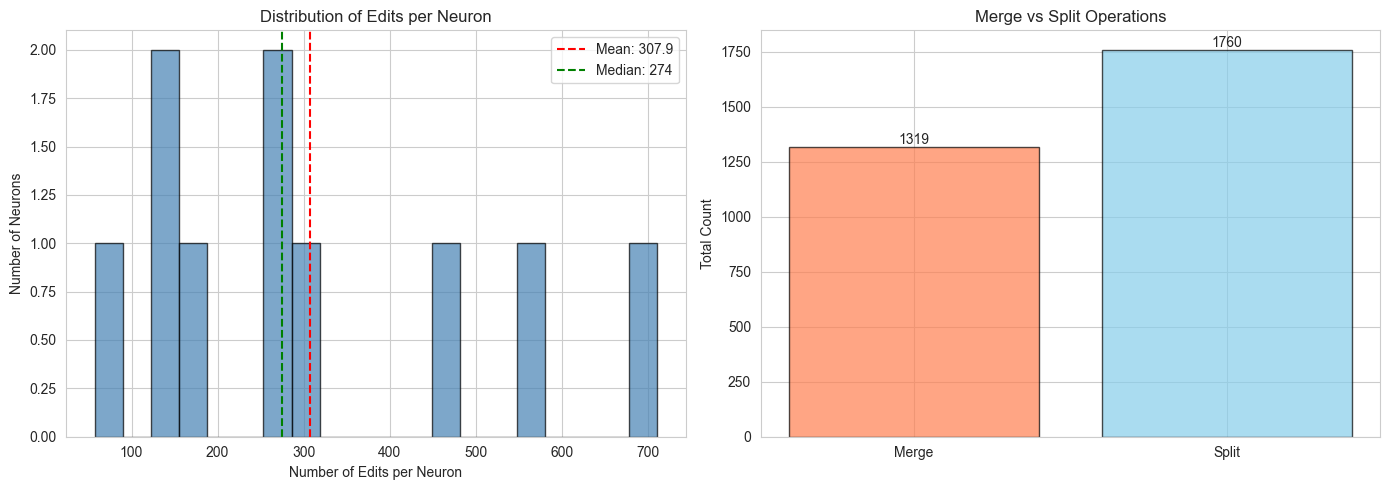

In [13]:
# Plot 1: Histogram of edits per neuron
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Edit distribution
axes[0].hist(results_df['total_edits'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(results_df['total_edits'].mean(), color='red', linestyle='--', 
                label=f'Mean: {results_df["total_edits"].mean():.1f}')
axes[0].axvline(results_df['total_edits'].median(), color='green', linestyle='--',
                label=f'Median: {results_df["total_edits"].median():.0f}')
axes[0].set_xlabel('Number of Edits per Neuron')
axes[0].set_ylabel('Number of Neurons')
axes[0].set_title('Distribution of Edits per Neuron')
axes[0].legend()

# Merge vs Split
merge_total = results_df['merge_edits'].sum()
split_total = results_df['split_edits'].sum()
axes[1].bar(['Merge', 'Split'], [merge_total, split_total], 
            color=['coral', 'skyblue'], edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Total Count')
axes[1].set_title('Merge vs Split Operations')
axes[1].text(0, merge_total + 0.5, f'{merge_total}', ha='center', va='bottom')
axes[1].text(1, split_total + 0.5, f'{split_total}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Step 6: Extrapolate to Full Dataset

Based on this sample, estimate costs for the full proofread dataset.

In [14]:
# Extrapolate
sample_size = len(results_df)
full_dataset_size = len(neuron_ids)
scaling_factor = full_dataset_size / sample_size

estimated_total_edits = int(results_df['total_edits'].sum() * scaling_factor)
estimated_merge_edits = int(results_df['merge_edits'].sum() * scaling_factor)
estimated_split_edits = int(results_df['split_edits'].sum() * scaling_factor)

print(f"Extrapolation to Full Dataset ({full_dataset_size:,} neurons):")
print(f"  Sample: {sample_size} neurons")
print(f"  Scaling factor: {scaling_factor:.1f}x")
print(f"\nEstimated totals:")
print(f"  Total edits: {estimated_total_edits:,}")
print(f"  Merge operations: {estimated_merge_edits:,}")
print(f"  Split operations: {estimated_split_edits:,}")
print(f"\nAverage per neuron: {results_df['total_edits'].mean():.2f} edits")

Extrapolation to Full Dataset (2,314 neurons):
  Sample: 10 neurons
  Scaling factor: 231.4x

Estimated totals:
  Total edits: 712,480
  Merge operations: 305,216
  Split operations: 407,264

Average per neuron: 307.90 edits


## Next Steps

To calculate GPU costs:
1. Multiply edit counts by computational cost per edit type
2. Cost per edit depends on:
   - Model: Qwen 32B on 2x H100 GPUs
   - Inference time per edit
   - GPU utilization

Formula:
```
Total Cost = (merge_edits × cost_per_merge) + (split_edits × cost_per_split)
```

This data provides the edit counts needed for that calculation!